# Handling Imbalanced Data in Machine Learning

當我們談到數據科學和分類建模時，一個常見且重要的挑戰是數據不平衡問題。這種問題在真實世界的資料集中經常出現，並且會對建模效果產生很大的影響。
讓我們用一個簡單的例子來說明這個問題。想像一下，我們是一家電信公司，正在嘗試通過簡訊推銷新產品。我們向數十萬名顧客發送了推銷簡訊，希望他們能夠回覆是否有興趣購買這個產品。然而，結果是絕大多數顧客根本沒有回覆，只有不到一千人表示有興趣。
這時，我們的資料集中會有非常不平衡的樣本：絕大多數都是“沒有回覆”或者“不感興趣”，而只有極少數是“有興趣”。這樣的數據不平衡會對我們的分類模型造成困擾，因為模型很容易被多數樣本所主導，結果變得不準確，無法正確識別少數樣本“有興趣”的情況。
當然，我們可以通過一些方法來改善這種情況。比如，使用集成學習方法（如隨機森林）或深度學習模型來提升分類效果。然而，這樣做也會帶來過擬合的風險，模型可能會對訓練數據過度學習，從而無法在新數據上表現良好。

# 以 Data-Level 的觀點處理資料不平衡問題

- **Oversampling**: Increase the number of samples in the minority class. Common techniques include Random Oversampling and Synthetic Minority Over-sampling Technique (SMOTE).
- **Undersampling**: Reduce the number of samples in the majority class. Techniques include Random Undersampling and NearMiss.
- **Data Augmentation**: Apply transformations (such as rotation, flipping, etc.) to the minority class samples to generate new samples.

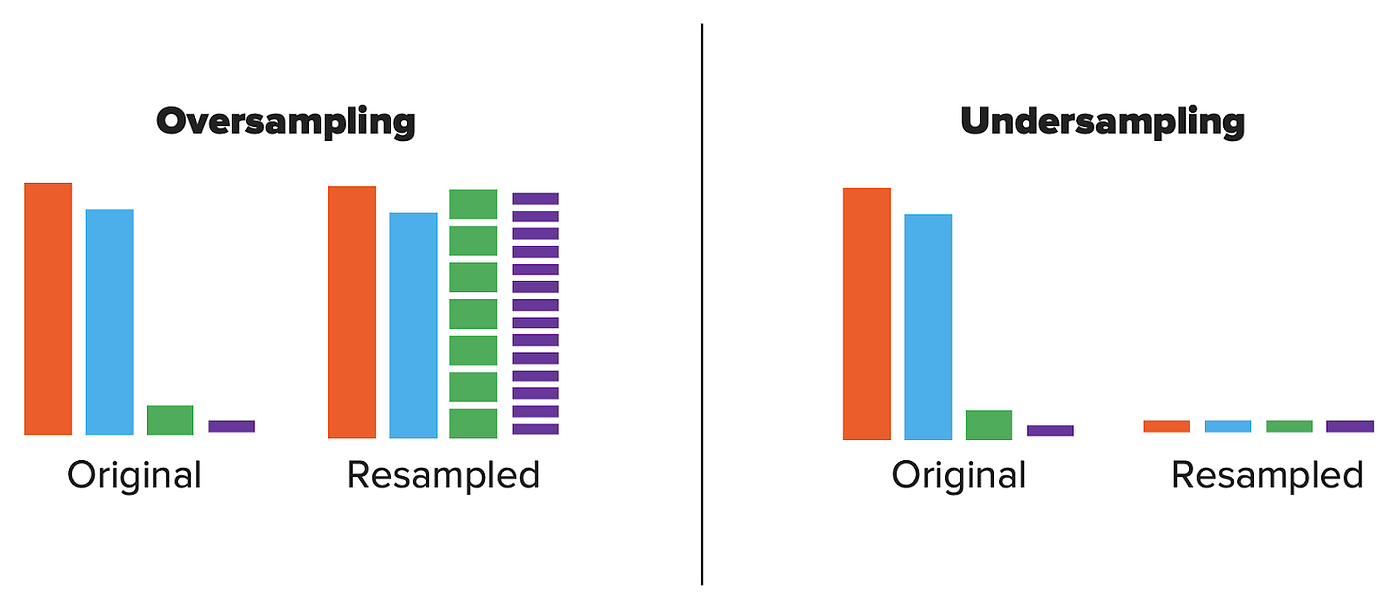

# 不平衡數據集分類建模流程

對資料做一些處理：這邊思路有兩種，一種是將多數樣本中比較不具代表性的拿除掉，以免造成雜訊，稱為欠採樣，第二種是將少數樣本用某種方式重複抽樣或合成新樣本，稱為過採樣；本篇除了介紹這兩種方法以外，也會嘗試將這兩種方法結合，並配合一般建模流程提出完善的解決方案。

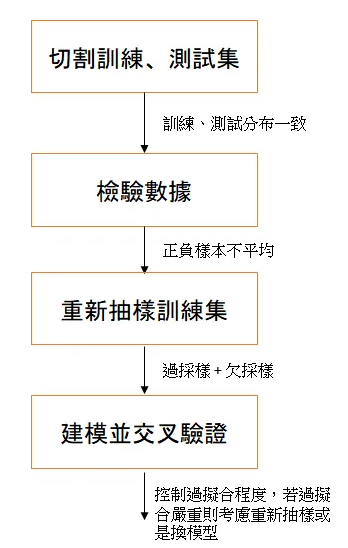


[ref](https://medium.com/%E6%95%B8%E5%AD%B8-%E4%BA%BA%E5%B7%A5%E6%99%BA%E6%85%A7%E8%88%87%E8%9F%92%E8%9B%87/smote-enn-%E8%A7%A3%E6%B1%BA%E6%95%B8%E6%93%9A%E4%B8%8D%E5%B9%B3%E8%A1%A1%E5%BB%BA%E6%A8%A1%E7%9A%84%E6%8E%A1%E6%A8%A3%E6%96%B9%E6%B3%95-cdb6324b711e)

In [79]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

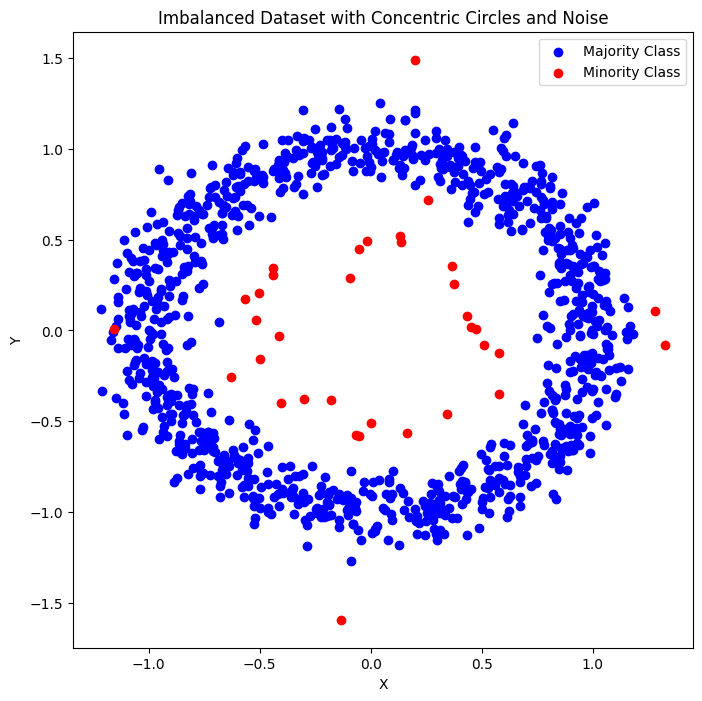

In [80]:

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate points in a circle
def generate_circle_points(r, n):
    angles = np.linspace(0, 2 * np.pi, n)
    x = r * np.cos(angles) + np.random.normal(0, 0.1, n)
    y = r * np.sin(angles) + np.random.normal(0, 0.1, n)
    return x, y

# Generate majority class (class 0)
majority_class_size = 1000
r_majority = 1
x_majority, y_majority = generate_circle_points(r_majority, majority_class_size)
majority_labels = np.zeros(majority_class_size)

# Generate minority class (class 1)
minority_class_size = 30
r_minority = 0.5
x_minority, y_minority = generate_circle_points(r_minority, minority_class_size)
minority_labels = np.ones(minority_class_size)

# Generate noise points outside the circles
noise_size = 5
r_noise_min = 1.2
r_noise_max = 1.5
angles_noise = np.linspace(0, 2 * np.pi, noise_size)
r_noise = np.random.uniform(r_noise_min, r_noise_max, noise_size)
x_noise = r_noise * np.cos(angles_noise) + np.random.normal(0, 0.1, noise_size)
y_noise = r_noise * np.sin(angles_noise) + np.random.normal(0, 0.1, noise_size)
noise_labels = np.ones(noise_size)  # Labeling noise points as part of the minority class

# Combine the datasets
x = np.concatenate((x_majority, x_minority, x_noise))
y = np.concatenate((y_majority, y_minority, y_noise))
labels = np.concatenate((majority_labels, minority_labels, noise_labels))

# Create a DataFrame
df = pd.DataFrame({'PCA1': x, 'PCA2': y, 'Class': labels})

df["Class"] = df["Class"].astype(int)

# Plot the dataset
plt.figure(figsize=(8, 8))
plt.scatter(df[df['Class'] == 0]['PCA1'], df[df['Class'] == 0]['PCA2'], c='blue', label='Majority Class')
plt.scatter(df[df['Class'] == 1]['PCA1'], df[df['Class'] == 1]['PCA2'], c='red', label='Minority Class')
plt.legend()
plt.title('Imbalanced Dataset with Concentric Circles and Noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [81]:
df.head()

,PCA1,PCA2,Class
0,1.049671,0.139936,0
1,0.986154,0.098753,0
2,1.064690,0.018542,0
3,1.152125,-0.045826,0
4,0.976268,0.094978,0


In [82]:
df["Class"].value_counts()

Class
0    1000
1      35
Name: count, dtype: int64

## Create Independent and dependent features

In [83]:
x=df.drop('Class',axis=1)
y=df['Class']

## Check imbalance data ratio b/w fraud and normal class

In [84]:
normal=df[df['Class']==0]
fraud=df[df['Class']==1]

print('No of fraud records of data: {}'.format(fraud.shape[0]))
print('No of normal records of data: {}'.format(normal.shape[0]))

print("imbalance ratio: {} %".format(np.round((fraud.shape[0]*100/normal.shape[0]), 2)))


No of fraud records of data: 35
No of normal records of data: 1000
imbalance ratio: 3.5 %


From the above figure we can say that there are more no of values in normal(0) class and no values in 1 class,so we can clearly say that the dataset is imbalanced


----

# Oversampling: 
Oversampling makes the class with less number of data to balance with the other class by increasing the no of records,so that the dataset will be balanced.Oversampling is better than downsampling because it gives more no of data whereas in downsampling we lose some amount of data.

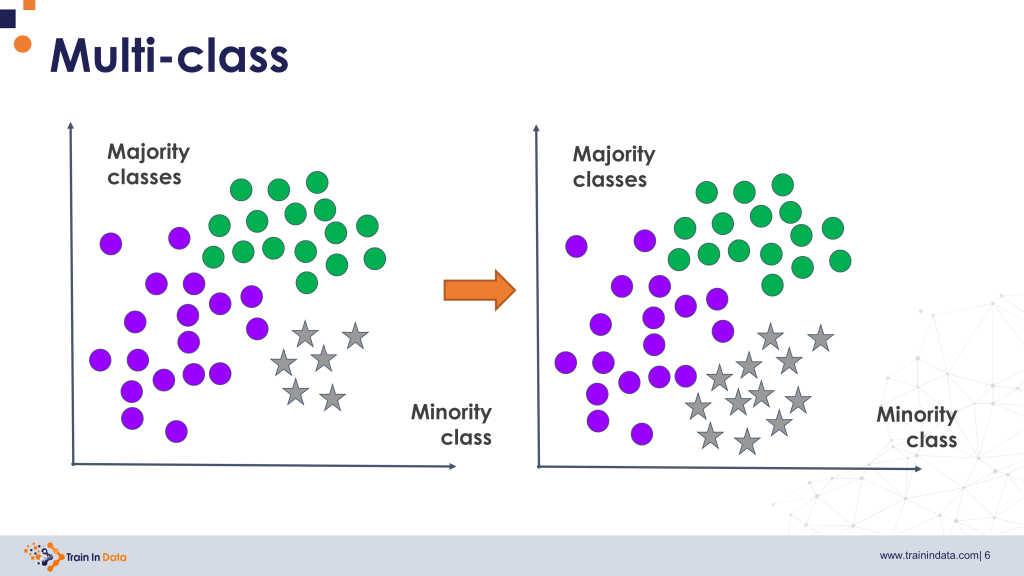

## Random Oversampling

Random oversampling is a technique used to address class imbalance in datasets by randomly duplicating samples from the minority class. This method increases the representation of the minority class, helping to balance the dataset and improve the performance of machine learning models. 

In [85]:
# Import necessary libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X=df.drop('Class',axis=1)
y=df['Class']

# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply random oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the resampled class distribution
print(f"Resampled class distribution: {Counter(y_resampled)}")


Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution: Counter({0: 1000, 1: 1000})


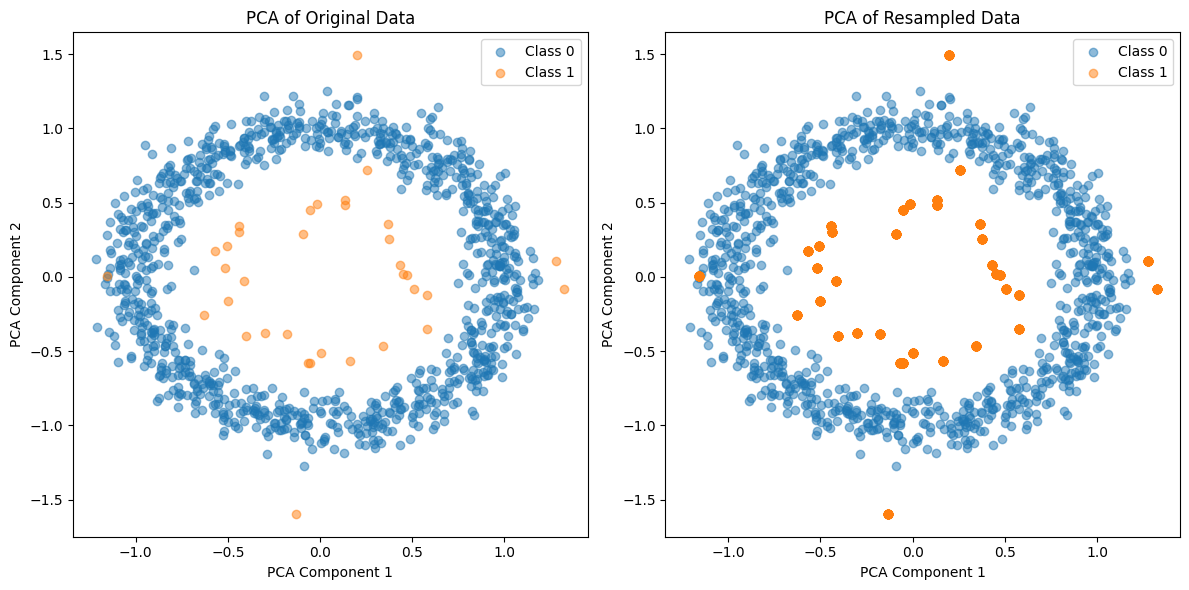

In [86]:
# 為了視覺化方便，挑兩個特徵出來
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled = X_resampled[["PCA1", "PCA2"]].values


# Create DataFrames for visualization
pca_df_original = pd.DataFrame(data=X_pca_original, columns=['PCA1', 'PCA2'])
pca_df_original['Class'] = y.values

pca_df_resampled = pd.DataFrame(data=X_pca_resampled, columns=['PCA1', 'PCA2'])
pca_df_resampled['Class'] = y_resampled.values

# Plot PCA of original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for class_value in pca_df_original['Class'].unique():
    subset = pca_df_original[pca_df_original['Class'] == class_value]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Class {class_value}', alpha=0.5)
plt.title('PCA of Original Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Plot PCA of resampled data
plt.subplot(1, 2, 2)
for class_value in pca_df_resampled['Class'].unique():
    subset = pca_df_resampled[pca_df_resampled['Class'] == class_value]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Class {class_value}', alpha=0.5)
plt.title('PCA of Resampled Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.show()

- 優點：
隨機過採樣的主要優點是簡單易行。它不需要複雜的算法或對數據底層分佈的假設，適用於任何有類別不平衡的數據集，且不需要對數據集有先驗知識。

- 局限性：
隨機過採樣可能導致過擬合，即模型對訓練數據過於特定，無法很好地泛化到新數據。原因在於隨機過採樣不會增加數據集的新信息，新增的樣本只是複製現有數據，因此無法提供更多關於少數類別的詳細信息，反而可能增加噪音。

Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution: Counter({0: 1000, 1: 1000})


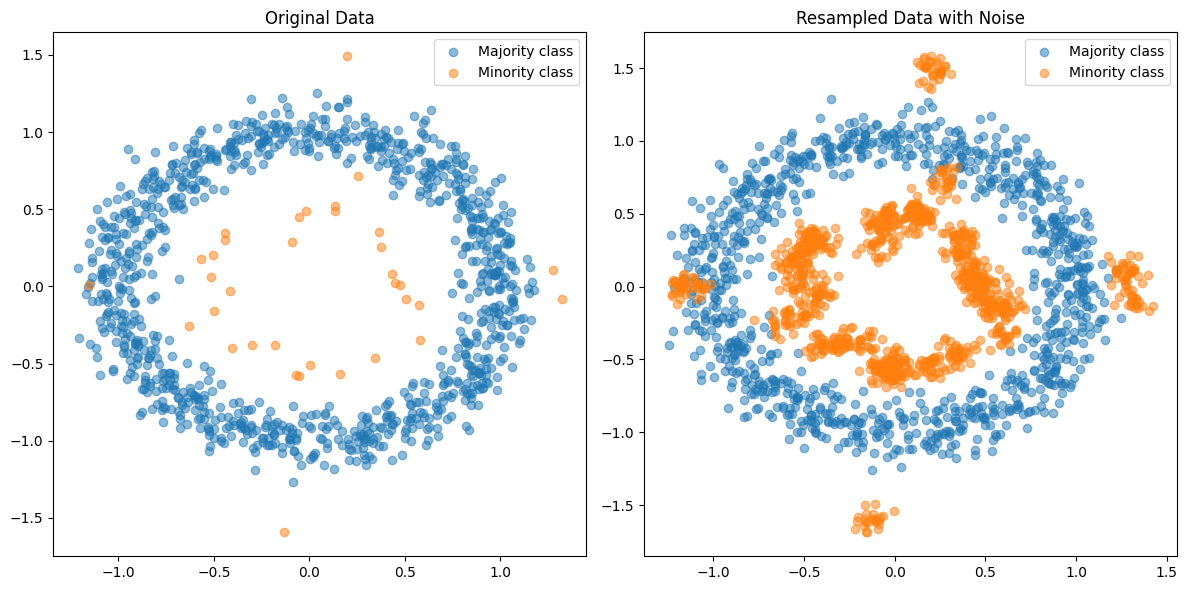

In [87]:
# Import necessary libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset

X = df.drop('Class', axis=1)
y = df['Class']

# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply random oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the resampled class distribution
print(f"Resampled class distribution: {Counter(y_resampled)}")

# Function to add noise to the resampled data
def add_noise(X, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    return X_noisy

# Add noise to the minority class instances
X_resampled_noisy = add_noise(X_resampled)

# 為了視覺化方便，挑兩個特徵出來
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled_noisy = X_resampled_noisy[["PCA1", "PCA2"]].values


plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_pca_original[y == 0, 0], X_pca_original[y == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_original[y == 1, 0], X_pca_original[y == 1, 1], alpha=0.5, label='Minority class')
plt.title('Original Data')
plt.legend()

# Resampled data with noise
plt.subplot(1, 2, 2)
plt.scatter(X_pca_resampled_noisy[y_resampled == 0, 0], X_pca_resampled_noisy[y_resampled == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled_noisy[y_resampled == 1, 0], X_pca_resampled_noisy[y_resampled == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data with Noise')
plt.legend()

plt.tight_layout()
plt.show()



## Synthesized Minority Oversampling Technique (SMOTE)

SMOTE, which stands for Synthetic Minority Oversampling Technique, is a popular oversampling method used to address class imbalance in machine learning.

The main idea behind the SMOTE algorithm is to generate synthetic data points of the minority class by interpolating between the minority class instances. In other words, SMOTE creates new data artificially.



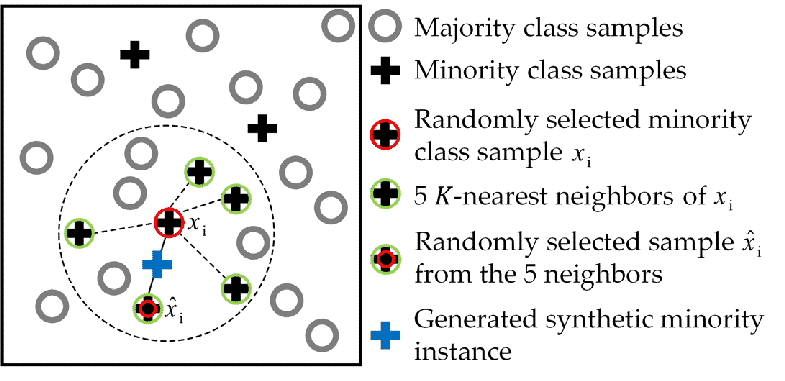

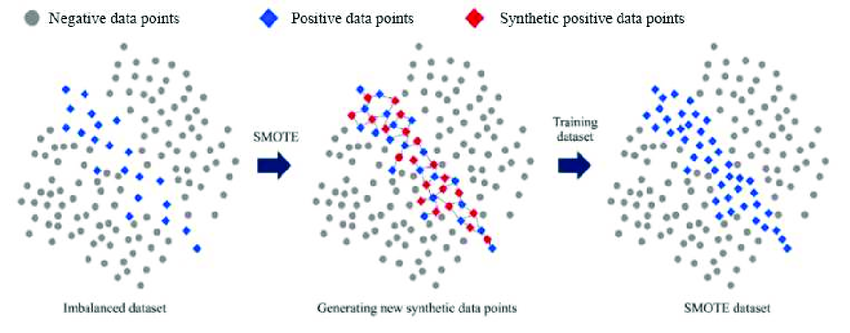


Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution: Counter({0: 1000, 1: 1000})


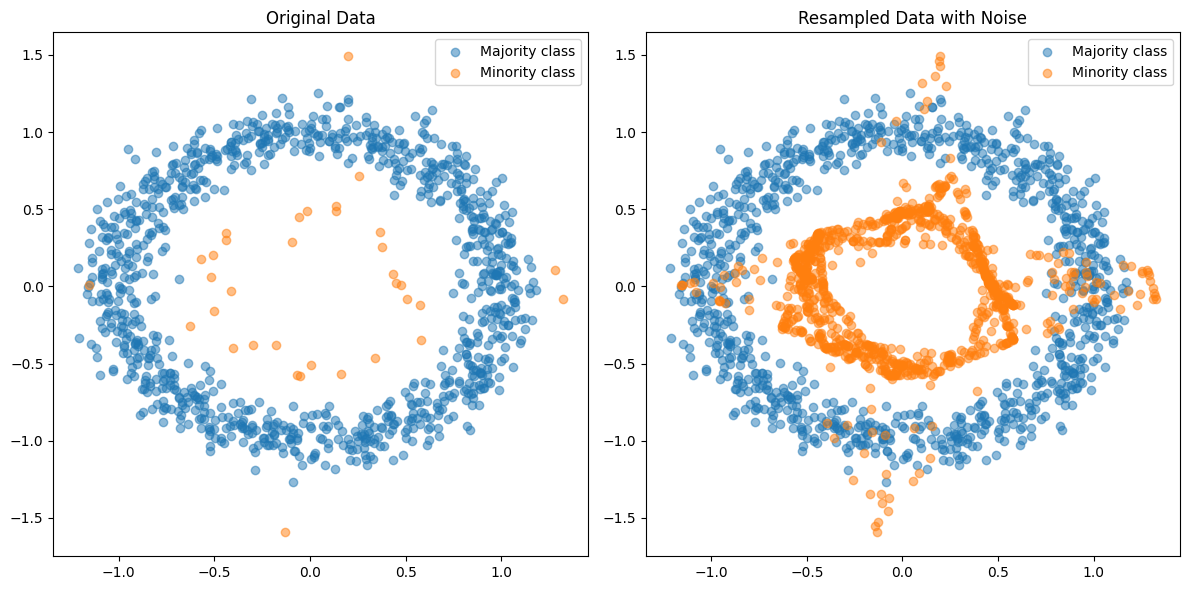

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load the dataset

X = df.drop('Class', axis=1)
y = df['Class']

# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize the SMOTE
sm = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=10)

# Apply SMOTE
X_res, y_res = sm.fit_resample(X, y)

# Check the resampled class distribution
print(f"Resampled class distribution: {Counter(y_res)}")


# 為了視覺化方便，挑兩個特徵出來
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled_noisy = X_res[["PCA1", "PCA2"]].values

plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_pca_original[y == 0, 0], X_pca_original[y == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_original[y == 1, 0], X_pca_original[y == 1, 1], alpha=0.5, label='Minority class')
plt.title('Original Data')
plt.legend()

# Resampled data with noise
plt.subplot(1, 2, 2)
plt.scatter(X_pca_resampled_noisy[y_res == 0, 0], X_pca_resampled_noisy[y_res == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled_noisy[y_res == 1, 0], X_pca_resampled_noisy[y_res == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data with Noise')
plt.legend()

plt.tight_layout()
plt.show()




## SMOTE + Tomek links

use Tomek links to clean the noisy samples. This can be done using the SMOTETomek approach, but you can also manually remove the Tomek links after applying SMOTE.

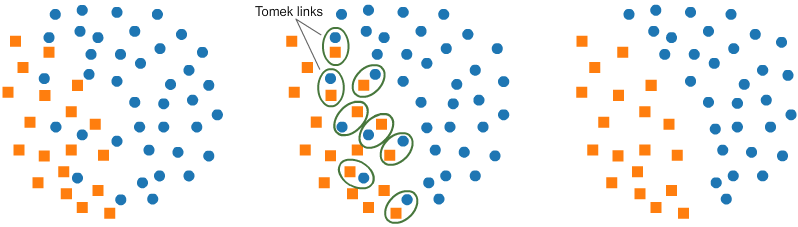

Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution: Counter({0: 979, 1: 979})


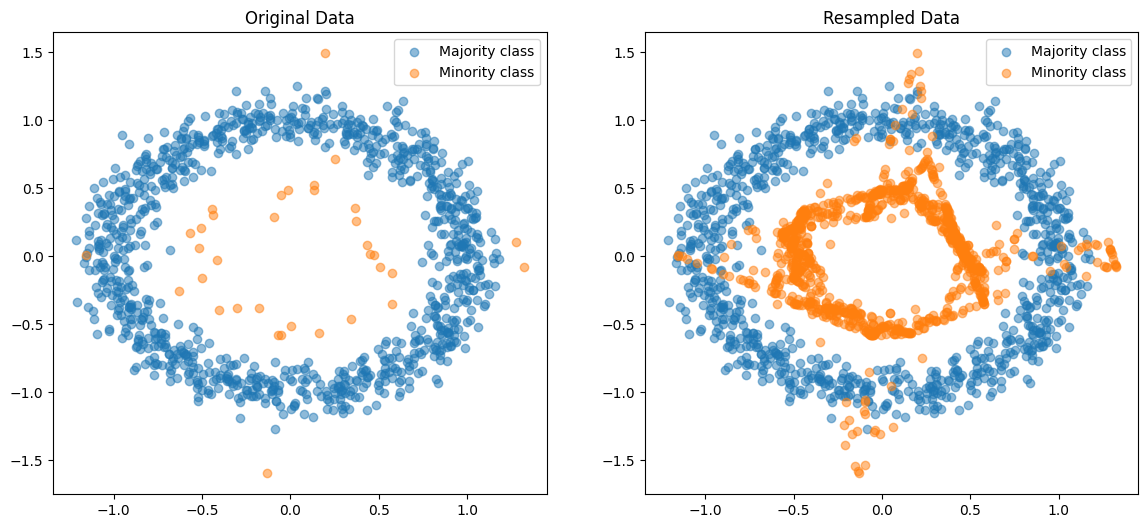

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from collections import Counter

# Assuming df is already loaded
# X = df.drop('Class', axis=1)
# y = df['Class']

# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize the SMOTETomek with adjusted parameters
smt = SMOTETomek(sampling_strategy='auto', random_state=0, smote=SMOTE(k_neighbors=10))

# Apply SMOTETomek
X_smote, y_smote = smt.fit_resample(X, y)

# Check the resampled class distribution
print(f"Resampled class distribution: {Counter(y_smote)}")

# For visualization, select two features
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled_smote = X_smote[["PCA1", "PCA2"]].values

plt.figure(figsize=(14, 6))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_pca_original[y == 0, 0], X_pca_original[y == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_original[y == 1, 0], X_pca_original[y == 1, 1], alpha=0.5, label='Minority class')
plt.title('Original Data')
plt.legend()

# Resampled data
plt.subplot(1, 2, 2)
plt.scatter(X_pca_resampled_smote[y_smote == 0, 0], X_pca_resampled_smote[y_smote == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled_smote[y_smote == 1, 0], X_pca_resampled_smote[y_smote == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data')
plt.legend()


plt.show()


# SMOTE Variants
## Borderline-SMOTE

One of the key limitations of SMOTE is that it generates synthetic samples along the line connecting the minority class sample to its nearest neighbors. This approach can lead to the misclassification of synthetic samples as the majority class, especially when the minority class sample is close to the decision boundary.

Borderline-SMOTE addresses this issue by only generating synthetic samples for minority-class samples close to the decision boundary. Under the hood, Borderline SMOTE uses templates to create the synthetic data observations from the minority, for which the majority of the neighbors are from the opposite class. Then, it interpolates between these instances and their minority class neighbors

Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution after cleaning: Counter({0: 1000, 1: 985})


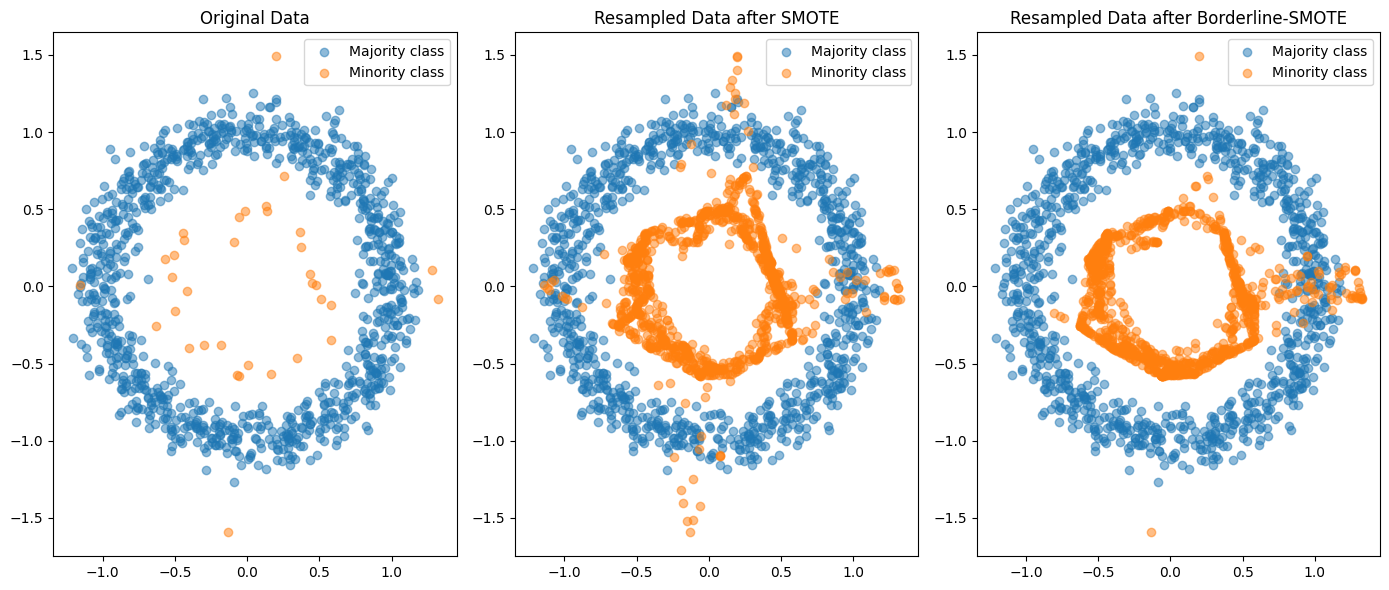

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize the Borderline-SMOTE
smote = BorderlineSMOTE(random_state=0, kind='borderline-1', k_neighbors=10)

# Apply Borderline-SMOTE
X_res, y_res = smote.fit_resample(X, y)

# Apply Tomek Links to clean the noisy samples
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_res, y_res)

# Check the resampled class distribution
print(f"Resampled class distribution after cleaning: {Counter(y_res)}")

# For visualization, select two features
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled = X_res[["PCA1", "PCA2"]].values

plt.figure(figsize=(14, 6))

# Original data
plt.subplot(1, 3, 1)
plt.scatter(X_pca_original[y == 0, 0], X_pca_original[y == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_original[y == 1, 0], X_pca_original[y == 1, 1], alpha=0.5, label='Minority class')
plt.title('Original Data')
plt.legend()

# Resampled data
plt.subplot(1, 3, 2)
plt.scatter(X_pca_resampled_smote[y_smote == 0, 0], X_pca_resampled_smote[y_smote == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled_smote[y_smote == 1, 0], X_pca_resampled_smote[y_smote == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data after SMOTE')
plt.legend()


# Resampled data
plt.subplot(1, 3, 3)
plt.scatter(X_pca_resampled[y_res == 0, 0], X_pca_resampled[y_res == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled[y_res == 1, 0], X_pca_resampled[y_res == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data after Borderline-SMOTE')
plt.legend()


plt.tight_layout()
plt.show()


## SVM-SMOTE

SVM-SMOTE is an alternative to Borderline SMOTE, where the data points that are used to create the synthetic data are the support vectors of a support vector machine separating the classes.

The synthetic data is created by interpolating between each minority class support vector and its nearest neighbors of the minority class. Hence, it creates more data points at the decision boundary.

Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution after cleaning: Counter({0: 1000, 1: 992})


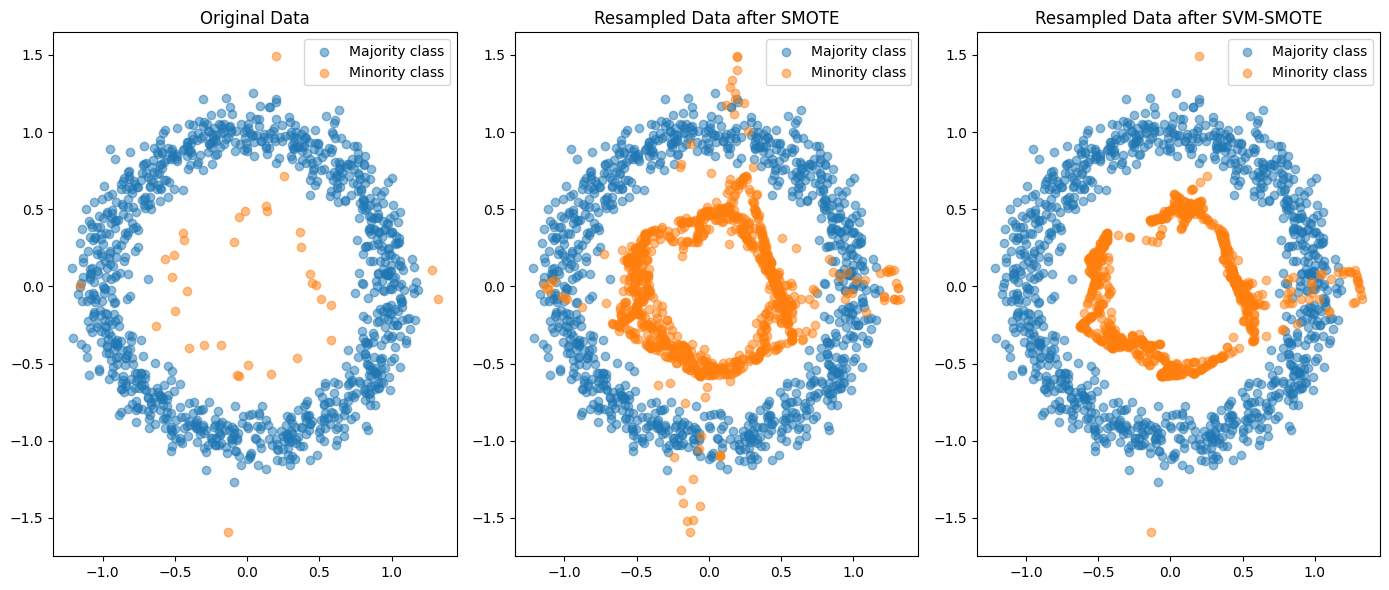

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter


# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize the SVM-SMOTE
smote = SVMSMOTE(random_state=0)

# Apply SVM-SMOTE
X_res, y_res = smote.fit_resample(X, y)

# Apply Tomek Links to clean the noisy samples
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_res, y_res)

# Check the resampled class distribution
print(f"Resampled class distribution after cleaning: {Counter(y_res)}")

# For visualization, select two features
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled = X_res[["PCA1", "PCA2"]].values

plt.figure(figsize=(14, 6))

# Original data
plt.subplot(1, 3, 1)
plt.scatter(X_pca_original[y == 0, 0], X_pca_original[y == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_original[y == 1, 0], X_pca_original[y == 1, 1], alpha=0.5, label='Minority class')
plt.title('Original Data')
plt.legend()

# Resampled data
plt.subplot(1, 3, 2)
plt.scatter(X_pca_resampled_smote[y_smote == 0, 0], X_pca_resampled_smote[y_smote == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled_smote[y_smote == 1, 0], X_pca_resampled_smote[y_smote == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data after SMOTE')
plt.legend()


# Resampled data
plt.subplot(1, 3, 3)
plt.scatter(X_pca_resampled[y_res == 0, 0], X_pca_resampled[y_res == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled[y_res == 1, 0], X_pca_resampled[y_res == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data after SVM-SMOTE')
plt.legend()

plt.tight_layout()
plt.show()


## Over-sampling with SMOTE and cleaning with ENN (SMOTEENN)

Original class distribution: Counter({0: 1000, 1: 35})
Resampled class distribution after additional cleaning: Counter({0: 983, 1: 934})


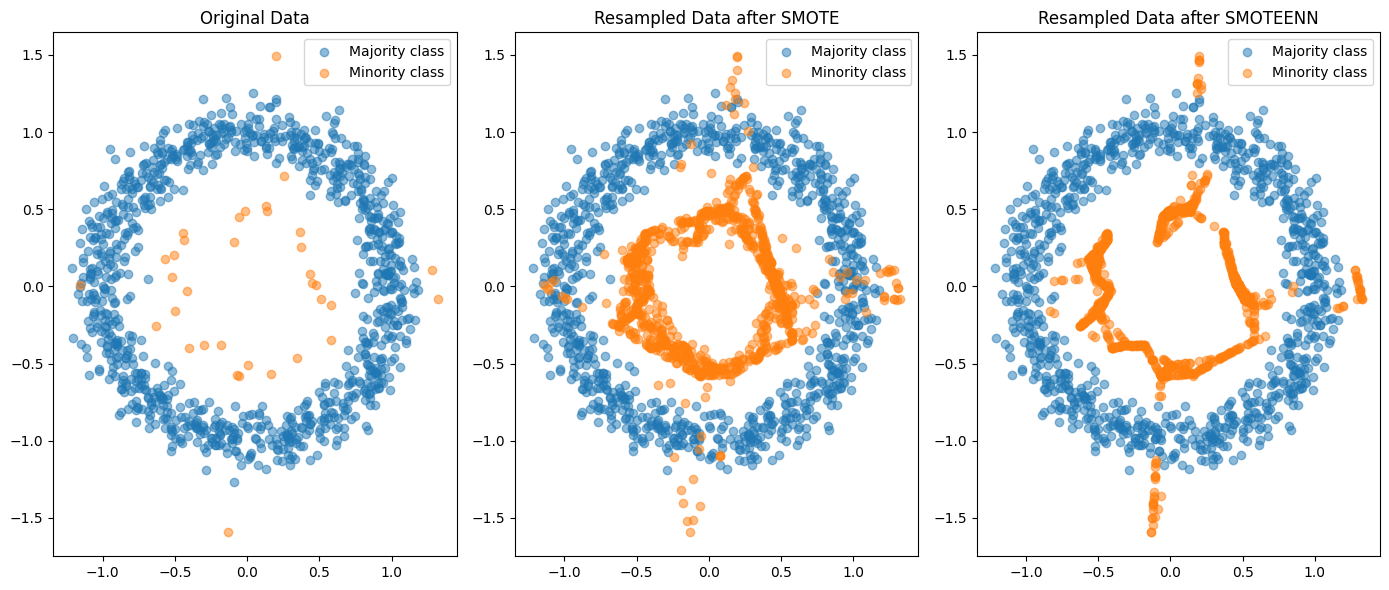

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter

# Assuming df is already loaded
# X = df.drop('Class', axis=1)
# y = df['Class']

# Check the original class distribution
print(f"Original class distribution: {Counter(y)}")

# Initialize SMOTETomek with adjusted parameters
smt = SMOTETomek(sampling_strategy='auto', random_state=0, smote=SMOTE(k_neighbors=3), tomek=TomekLinks(sampling_strategy='all'))

# Apply SMOTETomek
X_res, y_res = smt.fit_resample(X, y)

# Apply Edited Nearest Neighbours to clean the noisy samples further
enn = EditedNearestNeighbours(n_neighbors=3)
X_res, y_res = enn.fit_resample(X_res, y_res)

# Check the resampled class distribution after additional cleaning
print(f"Resampled class distribution after additional cleaning: {Counter(y_res)}")

# For visualization, select two features
X_pca_original = X[["PCA1", "PCA2"]].values
X_pca_resampled = X_res[["PCA1", "PCA2"]].values

plt.figure(figsize=(14, 6))

# Original data
plt.subplot(1, 3, 1)
plt.scatter(X_pca_original[y == 0, 0], X_pca_original[y == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_original[y == 1, 0], X_pca_original[y == 1, 1], alpha=0.5, label='Minority class')
plt.title('Original Data')
plt.legend()

# Resampled data
plt.subplot(1, 3, 2)
plt.scatter(X_pca_resampled_smote[y_smote == 0, 0], X_pca_resampled_smote[y_smote == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled_smote[y_smote == 1, 0], X_pca_resampled_smote[y_smote == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data after SMOTE')
plt.legend()

# Resampled data
plt.subplot(1, 3, 3)
plt.scatter(X_pca_resampled[y_res == 0, 0], X_pca_resampled[y_res == 0, 1], alpha=0.5, label='Majority class')
plt.scatter(X_pca_resampled[y_res == 1, 0], X_pca_resampled[y_res == 1, 1], alpha=0.5, label='Minority class')
plt.title('Resampled Data after SMOTEENN')
plt.legend()

plt.tight_layout()
plt.show()


先過濾離群，再做SMOTE，效果較優